# Определение тональности (токсичности) текста

Нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75.

In [329]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from tqdm import notebook

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import re
from gensim.parsing.preprocessing import remove_stopwords

from  nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

In [157]:
#import nltk
#nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [159]:
try:
    data = pd.read_csv("g:/Projects/praktikum/datasets/toxic_comments.csv")
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [160]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Имеем корпус из 160к твитов.
* text - текст твита
* toxic - признак токсичности текста

# 1. Обработка данных

Предобработку данных будем осуществлять по следующей схеме (для каждой строки):
1. Токенизируем текст
2. Лемматизируем токены, используя Wordnet.
3. Удаляем из лемматизированного текста стоп-слова, используя Gensim.
4. Очищаем текст от лишних символов, за исключением букв английского алфавита и пробелов.

In [161]:
# иницируем лемматайзер
wn_lemmatizer = WordNetLemmatizer()

In [338]:
# функция берёт строку и проводит очистку, возвращая чистую строку
def clear_text(row):
    text = row['text']
    
    # токенизация
    tokens = word_tokenize(text)
    lemm_result = []
    
    # лемматизация
    for word in tokens:
        lemm_result.append(wn_lemmatizer.lemmatize(word, pos='v'))
        lemm_result.append(' ')
    lemms_line = "".join(lemm_result)
    
    # удаление стоп-слов
    text_no_sw = remove_stopwords(lemms_line)
    
    # очистка от мусора
    clear_lemms = re.sub(r'[^a-zA-Z]', ' ', text_no_sw)
    clear_text = " ".join(clear_lemms.split())
   
    return clear_text

In [339]:
notebook.tqdm.pandas()
data['clear_lemms'] = data.progress_apply(stem_Sent2, axis=1)

G:\Anaconda\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [340]:
# чтобы не делать долгую лемматизацию каждый раз, сохраним результат
data.to_csv('toxic_c_clear.csv', index=False)
del data

Загрузим подготовленный файл, с очищенным текстом.

In [341]:
data=pd.read_csv('toxic_c_clear.csv')

#некоторые твиты в исходных данных были некорректны, и в результате получили пустые строки с леммами - выбрасываем
data.dropna(inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159535 entries, 0 to 159534
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         159535 non-null  object
 1   toxic        159535 non-null  int64 
 2   clear_lemms  159535 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


Супер! Приступаем к подготовке к обучению!

## 2. Подготовка признаков

In [342]:
corpus = data['clear_lemms']
label = data['toxic']

Посмотрим на распределение целевого признака.

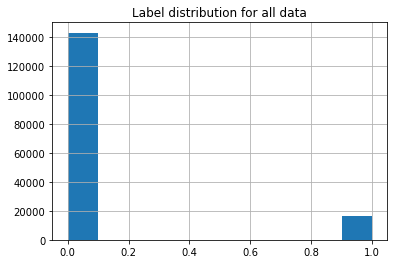

In [347]:
label.hist()
plt.title('Label distribution for all data')
plt.show()

Признак не сбалансирован - токсичных комментариев существенно меньше! Это станет проблемой - вместо обучения определять токсичные слова и словосочетания, модели будут забивать память ненужными данными из обычных комментов. <br/>
Лучшим решением здесь видится downsampling обучающей выборки, чтобы модели лучше опознали разницу между токсичными и обычными комментами.

Сначала отделим 0.25 комментариев на тестовую выборку.

In [349]:
corpus_train, corpus_test, label_train, label_test = train_test_split(corpus, label, test_size=0.25)
print('Train corpus:', corpus_train.shape)
print('Test corpus:', corpus_test.shape)

Train corpus: (119651,)
Test corpus: (39884,)


In [351]:
# функция принимает признаки и долю даунсемпла, уменьшает кол-во отрицательных признаков, перемешивает и возвращает балансированные признаки

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled


In [352]:
# применим функцию к ТРЕНИРОВОЧНОЙ выборке, сократив количество отрицательных объектов в 5 раз
corpus_downsampled, label_downsampled = downsample(corpus_train, label_train, 0.2)

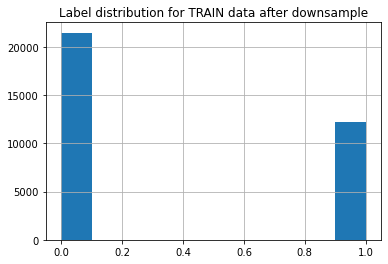

In [353]:
label_downsampled.hist()
plt.title('Label distribution for TRAIN data after downsample')
plt.show()

Уже лучше!

Теперь векторизируем признаки. <br/>
Используем алгоритм TF-IDF для получения векторов слов и их встречаемости в комментариях.

In [355]:
# инициализируем векторайзер и фитим на обучающей выборке
count_tfidf = TfidfVectorizer()
count_tfidf.fit(corpus_downsampled)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [357]:
# трансформируем обучающий и тестовый корпуса
tf_idf_train = count_tfidf.transform(corpus_downsampled)
tf_idf_test = count_tfidf.transform(corpus_test)

print('Train corpus', tf_idf_train.shape)
print('Label train', label_downsampled.shape)
print('---')
print('Test corpus', tf_idf_test.shape)
print('Test label', label_test.shape)

Train corpus (33694, 62050)
Label train (33694,)
---
Test corpus (39884, 62050)
Test label (39884,)


Данные готовы к обучению моделей!

# 3. Обучение и тестирование моделей

In [365]:
# функция для теста. На вход - модель, на выходе метрики и ROC-график
def test_me(cur_model):    
    #probs and ROC-AUC
    probabilities_test = cur_model.predict_proba(tf_idf_test)
    probabilities_one_test = probabilities_test[:, 1]
    fpr, tpr, thresholds = roc_curve(label_test, probabilities_one_test)
    
    # F1 score
    predictions = cur_model.predict(tf_idf_test)
    f1 = f1_score(label_test, predictions)
    print('F1_Score=', f1)
    
    #график
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
            
    # AUC-ROC SCORE
    auc_roc = roc_auc_score(label_test, probabilities_one_test)
    print('ROC-AUC Score=', auc_roc)
    
    plt.show()
    return f1

In [369]:
result = pd.DataFrame(columns = ['F1_score'])

## 3.1 Logistic Regression

In [363]:
model_lr = LogisticRegression()
model_lr.fit(tf_idf_train, label_downsampled)

G:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

F1_Score= 0.7515322960867514
ROC-AUC Score= 0.9672599173166272


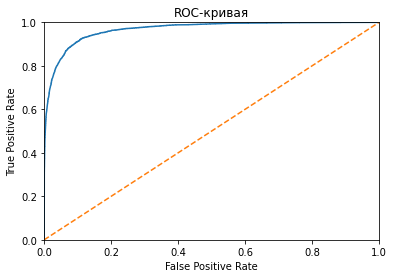

In [370]:
f1_lr = test_me(model_lr)

In [371]:
# собираем результаты тестов в табличку
result.loc['LogRegression'] = f1_lr
result

,F1_score
LogRegression,0.751532


## 3.2 RandomForestClassifier

In [372]:
# функция для обучения gridsearch
def RFC_grid(feat, targ):
    estimator = RandomForestClassifier(random_state=112211)
    param_grid = {
            "n_estimators"      : [500,1000],
            "max_features"      : ["auto"],
            "min_samples_leaf" : [1],
            "min_samples_split" : [10,20],
            "bootstrap": [False],
                }

    rfr_grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=3, scoring='f1')
    rfr_grid.fit(feat, targ)

    print('...Search completed...')
    print('Best RMSE score', rfr_grid.best_score_)
    print('Best params:', rfr_grid.best_params_)

    return rfr_grid.best_params_

In [382]:
#RFC_params = RFC_grid(tf_idf_train, label_downsampled)
RFC_params = {'bootstrap': False, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 500}

In [374]:
model_rfc = RandomForestClassifier(**RFC_params)
model_rfc.fit(tf_idf_train, label_downsampled)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

F1_Score= 0.7362495602204762
ROC-AUC Score= 0.9626401700524211


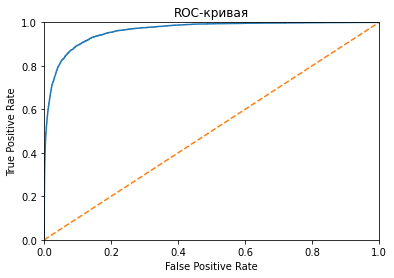

In [378]:
f1_rfc = test_me(model_rfc)

In [379]:
result.loc['RFClassifier'] = f1_rfc
result

,F1_score
LogRegression,0.751532
RFClassifier,0.736250


## 3.3 Linear Support Vector Classifier

In [380]:
model_svc = LinearSVC(tol=1e-5)
model_svc.fit(tf_idf_train, label_downsampled)

predict = model_svc.predict(tf_idf_test)
f1_score(label_test, predict)

0.7486181737784655

In [381]:
result.loc['LinearSVC'] = f1_score(label_test, predict)
result

,F1_score
LogRegression,0.751532
RFClassifier,0.736250
LinearSVC,0.748618


## 3.4 AdaBoostClassifier

In [383]:
model_abc = AdaBoostClassifier(n_estimators=500, learning_rate=0.5)
model_abc.fit(tf_idf_train, label_downsampled)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=200, random_state=None)

F1_Score= 0.7244112578977598
ROC-AUC Score= 0.9444912352926138


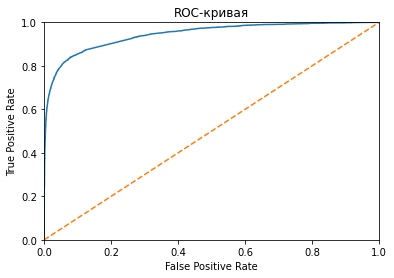

In [384]:
f1_ada = test_me(model_abc)

In [385]:
result.loc['AdaBoostClassifier'] = f1_ada
result

,F1_score
LogRegression,0.751532
RFClassifier,0.736250
LinearSVC,0.748618
AdaBoostClassifier,0.724411
